In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy.stats import f_oneway, uniform

from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import kernel_metrics, chi2_kernel
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

`sklearn.metrics.pairwise.kernel_metrics()` to list available kernels

In [2]:
kernel_metrics()

{'additive_chi2': <function sklearn.metrics.pairwise.additive_chi2_kernel(X, Y=None)>,
 'chi2': <function sklearn.metrics.pairwise.chi2_kernel(X, Y=None, gamma=1.0)>,
 'linear': <function sklearn.metrics.pairwise.linear_kernel(X, Y=None, dense_output=True)>,
 'polynomial': <function sklearn.metrics.pairwise.polynomial_kernel(X, Y=None, degree=3, gamma=None, coef0=1)>,
 'poly': <function sklearn.metrics.pairwise.polynomial_kernel(X, Y=None, degree=3, gamma=None, coef0=1)>,
 'rbf': <function sklearn.metrics.pairwise.rbf_kernel(X, Y=None, gamma=None)>,
 'laplacian': <function sklearn.metrics.pairwise.laplacian_kernel(X, Y=None, gamma=None)>,
 'sigmoid': <function sklearn.metrics.pairwise.sigmoid_kernel(X, Y=None, gamma=None, coef0=1)>,
 'cosine': <function sklearn.metrics.pairwise.cosine_similarity(X, Y=None, dense_output=True)>}

Each of these are interesting in their own ways, but the most applicable to our case will be `additive_chi2` and `chi2`, `linear`, `rbf` and `laplacian`. We will do trials of each, but `rbf` will be approximated using the `sklearn.kernel_approximation.Nystroem` method since it is intractable with so many samples especially if we need to enable probability prediction.

## Data Read

In [2]:
d_full = pd.read_csv('../data/d_full.csv')

#d_sub = pd.read_csv('../data/d_sub.csv')

x, y = *(d_full.drop('label', axis=1),
         d_full['label']),

x, y = map(lambda j: j.to_numpy(), (x,y))

## SGD Initialization

In [4]:
sgd = SGDClassifier(loss='log',
                    penalty='l1',
                    #early_stopping=True,
                    class_weight='balanced',
                    n_jobs=-1)

## Example Nystroem Approximation

In [5]:
chi2_approx = Nystroem(kernel='rbf').fit_transform(x, y)
chi2_approx

array([[0.08218893, 0.11569098, 0.08064164, ..., 0.11999643, 0.0899466 ,
        0.08386056],
       [0.08559214, 0.11470791, 0.08486275, ..., 0.11688105, 0.0901929 ,
        0.08318053],
       [0.08095815, 0.11704214, 0.07965122, ..., 0.11822954, 0.08743916,
        0.08382805],
       ...,
       [0.08265965, 0.10744433, 0.07744192, ..., 0.10948361, 0.07700813,
        0.08370128],
       [0.08162117, 0.10817228, 0.07647797, ..., 0.11113562, 0.07968529,
        0.08349944],
       [0.08096422, 0.11572959, 0.07961413, ..., 0.1221343 , 0.09678979,
        0.08282129]])

In [6]:
scores = cross_val_score(sgd, chi2_approx, y, scoring='precision_micro', cv=5)
scores

array([0.68130145, 0.6127009 , 0.63426107, 0.63857311, 0.58156863])

In [7]:
scores = cross_val_score(sgd, chi2_approx, y, scoring='recall_micro', cv=5)
scores

array([0.65307722, 0.61466092, 0.59858879, 0.63622109, 0.55882353])

In [8]:
def train(clf, x, y, kernel='rbf', scoring=None, folds=5, verbose=0, **kwargs):
    approx = Nystroem(kernel=kernel, kernel_params=dict(**kwargs)).fit_transform(x, y)
    return cross_val_score(clf,
                           approx, y,
                           scoring=scoring,
                           cv=StratifiedKFold(n_splits=folds, shuffle=True),
                           verbose=verbose, n_jobs=-1)

## Trials

In [9]:
#np.set_printoptions(precision=2)
sgd = SGDClassifier(loss='log',
                    penalty='l1',
                    #early_stopping=True,
                    #class_weight='balanced',
                    n_jobs=-1, warm_start=False)
kernels_to_try = ('additive_chi2', 'chi2', 'linear', 'rbf', 'laplacian')
scoring = 'recall_weighted'
folds=10
df = {}
for kernel in kernels_to_try:
    scores = train(sgd,
                   x, y,
                   folds=folds,
                   kernel=kernel,
                   scoring=scoring)
    df[kernel] = scores
    print(kernel, ' done...')
f_result = f_oneway(*df.values())
df = pd.DataFrame(df)
df

additive_chi2  done...
chi2  done...
linear  done...
rbf  done...
laplacian  done...


,additive_chi2,chi2,linear,rbf,laplacian
0,0.680251,0.706897,0.651254,0.670846,0.661442
1,0.692006,0.714734,0.664577,0.641066,0.683386
2,0.692790,0.692006,0.653605,0.659091,0.660658
3,0.692790,0.699843,0.644201,0.641850,0.679467
4,0.694902,0.723922,0.653333,0.647059,0.676078
5,0.697255,0.698824,0.660392,0.632157,0.666667
6,0.675294,0.683922,0.633725,0.680000,0.656471
7,0.707451,0.709804,0.672157,0.664314,0.672157
8,0.690196,0.716078,0.654118,0.638431,0.662745
9,0.694902,0.727843,0.661961,0.650980,0.664314


In [10]:
df.mean()

additive_chi2    0.691784
chi2             0.707387
linear           0.654932
rbf              0.652579
laplacian        0.668338
dtype: float64

In [11]:
f_result

F_onewayResult(statistic=40.16283798006535, pvalue=2.635044357090929e-14)

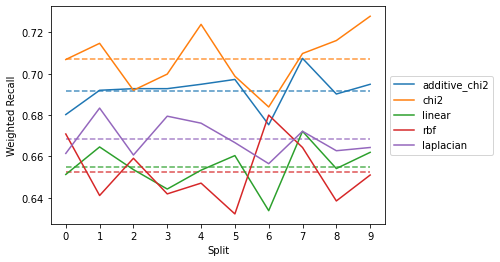

In [12]:
ax = df.plot(use_index=True, xticks=range(folds))
ax.hlines(df.mean(),
          xmin=0, xmax=folds-1,
          linestyles='dashed', alpha=0.8, colors=['C'+str(i) for i in range(5)])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.xlabel('Split');
plt.ylabel('Weighted Recall');

$\chi^2$ does best on average across several runs, so we will use it as our real kernel.

In [13]:
pl_grid = {#'kernel__n_components': np.linspace(100, 600, num=10, dtype=int),
           'kernel__gamma': np.logspace(-3, 3, num=5),
           'clf__loss': ('hinge', 'log'),
           'clf__penalty': ('l2', 'l1'),
           #'clf__learning_rate': ('optimal', 'invscaling', 'adaptive'),
           #'clf__power_t': np.logspace(-3, -1, num=10),
           #'clf__eta0': np.logspace(-3, -2, num=10),
           'clf__class_weight': ('balanced', None)
           }

sgd_grid = {#'kernel__n_components': np.linspace(100, 600, num=10, dtype=int),
            #'kernel__gamma': np.logspace(-3, 3, num=10),
            'loss': ('hinge', 'log'),
            'penalty': ('l2', 'l1'),
            'learning_rate': ('optimal', 'invscaling', 'adaptive'),
            'power_t': np.logspace(-3, -1, num=10),
            'class_weight': ('balanced', None)
            }

pipeline_steps = [('kernel', Nystroem(kernel='chi2', n_components=600)), ('clf', SGDClassifier(eta0=1, average=True))]

In [14]:
grid1 = RandomizedSearchCV(estimator=SGDClassifier(eta0=1, average=True),
                           cv=5, scoring='precision_micro',
                           param_distributions=sgd_grid,
                           verbose=3, n_jobs=-1)

grid1.fit(x,y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.7s finished


RandomizedSearchCV(cv=5, estimator=SGDClassifier(average=True, eta0=1),
                   n_jobs=-1,
                   param_distributions={'class_weight': ('balanced', None),
                                        'learning_rate': ('optimal',
                                                          'invscaling',
                                                          'adaptive'),
                                        'loss': ('hinge', 'log'),
                                        'penalty': ('l2', 'l1'),
                                        'power_t': array([0.001     , 0.0016681 , 0.00278256, 0.00464159, 0.00774264,
       0.0129155 , 0.02154435, 0.03593814, 0.05994843, 0.1       ])},
                   scoring='precision_micro', verbose=3)

In [15]:
# sorting by rank is equivalent to sorting by
# ['mean_test_score', 'std_test_score'] descending
grid1_df = pd.DataFrame(grid1.cv_results_).sort_values('rank_test_score')
grid1_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_power_t,param_penalty,param_loss,param_learning_rate,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.301899,0.012858,0.0024,0.000374,0.0215443,l2,log,optimal,None,"{'power_t': 0.021544346900318832, 'penalty': '...",0.636613,0.580165,0.666405,0.676205,0.594902,0.630858,0.037989,1
8,0.170800,0.034601,0.0021,0.000374,0.0016681,l2,hinge,invscaling,None,"{'power_t': 0.0016681005372000592, 'penalty': ...",0.633085,0.583301,0.657781,0.673069,0.583529,0.626153,0.037155,2
5,0.265500,0.016000,0.0024,0.000200,0.0215443,l2,hinge,optimal,None,"{'power_t': 0.021544346900318832, 'penalty': '...",0.624853,0.586829,0.642885,0.669541,0.569804,0.618782,0.036371,3
3,0.399500,0.027025,0.0021,0.000374,0.00774264,l1,log,optimal,None,"{'power_t': 0.007742636826811269, 'penalty': '...",0.647197,0.555468,0.591533,0.571149,0.491765,0.571422,0.050490,4
4,0.457900,0.014288,0.0024,0.000374,0.0359381,l1,hinge,optimal,None,"{'power_t': 0.03593813663804626, 'penalty': 'l...",0.446100,0.454332,0.398667,0.390043,0.403922,0.418613,0.026311,5
6,1.705399,0.044605,0.0049,0.005314,0.00774264,l1,log,adaptive,None,"{'power_t': 0.007742636826811269, 'penalty': '...",0.308114,0.311250,0.309682,0.239122,0.199608,0.273555,0.045988,6
7,1.755199,0.101269,0.0019,0.000583,0.00464159,l1,log,adaptive,balanced,"{'power_t': 0.004641588833612777, 'penalty': '...",0.345747,0.190122,0.250098,0.263034,0.149804,0.239761,0.066989,7
9,1.153099,0.032987,0.0020,0.000316,0.00774264,l1,hinge,adaptive,None,"{'power_t': 0.007742636826811269, 'penalty': '...",0.224226,0.222658,0.152489,0.167385,0.176078,0.188567,0.029462,8
1,0.451499,0.033861,0.0025,0.000633,0.00278256,l1,log,invscaling,None,"{'power_t': 0.0027825594022071257, 'penalty': ...",0.168953,0.133281,0.263818,0.163465,0.211373,0.188178,0.045284,9
0,0.435600,0.030670,0.0025,0.000316,0.0129155,l1,log,invscaling,balanced,"{'power_t': 0.01291549665014884, 'penalty': 'l...",0.118777,0.161113,0.246570,0.163465,0.161176,0.170220,0.041680,10


In [24]:
#fm = Nystroem(kernel='chi2', n_components=300).fit_transform(x, y)

pl = Pipeline(pipeline_steps)

grid = RandomizedSearchCV(estimator=pl,
                          cv=5, scoring='precision_micro',
                          param_distributions=pl_grid,
                          verbose=3, n_jobs=-1)

grid.fit(x,y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   43.1s finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('kernel',
                                              Nystroem(kernel='chi2',
                                                       n_components=600)),
                                             ('clf',
                                              SGDClassifier(average=True,
                                                            eta0=1))]),
                   n_jobs=-1,
                   param_distributions={'clf__class_weight': ('balanced', None),
                                        'clf__loss': ('hinge', 'log'),
                                        'clf__penalty': ('l2', 'l1'),
                                        'kernel__gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03])},
                   scoring='precision_micro', verbose=3)

In [25]:
# sorting by rank is equivalent to sorting by
# ['mean_test_score', 'std_test_score'] descending
grid_df = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')
grid_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel__gamma,param_clf__penalty,param_clf__loss,param_clf__class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,4.673799,0.139935,0.212701,0.026076,0.0316228,l2,hinge,None,"{'kernel__gamma': 0.03162277660168379, 'clf__p...",0.623285,0.609565,0.629165,0.671501,0.581176,0.622939,0.029394,1
8,4.483399,0.418292,0.187601,0.007193,0.0316228,l2,log,balanced,"{'kernel__gamma': 0.03162277660168379, 'clf__p...",0.656605,0.624461,0.611133,0.611525,0.579216,0.616588,0.024962,2
2,3.824900,0.129607,0.205599,0.013216,31.6228,l2,hinge,None,"{'kernel__gamma': 31.622776601683793, 'clf__pe...",0.633869,0.602509,0.578597,0.611917,0.591765,0.603731,0.018718,3
0,4.995798,0.199042,0.219500,0.022788,0.001,l2,log,balanced,"{'kernel__gamma': 0.001, 'clf__penalty': 'l2',...",0.606429,0.586045,0.587221,0.585261,0.597255,0.592442,0.008229,4
6,3.638700,0.133739,0.202401,0.011737,31.6228,l2,log,None,"{'kernel__gamma': 31.622776601683793, 'clf__pe...",0.611133,0.597413,0.565661,0.580557,0.596078,0.590168,0.015620,5
7,5.260199,0.392041,0.342702,0.041097,1000,l2,log,balanced,"{'kernel__gamma': 1000.0, 'clf__penalty': 'l2'...",0.306546,0.306938,0.306938,0.306938,0.307059,0.306884,0.000175,6
9,8.174596,0.095371,0.215004,0.032487,1000,l1,log,None,"{'kernel__gamma': 1000.0, 'clf__penalty': 'l1'...",0.306546,0.306546,0.305762,0.305370,0.306275,0.306100,0.000464,7
1,6.882897,0.424651,0.216201,0.038242,1,l1,log,None,"{'kernel__gamma': 1.0, 'clf__penalty': 'l1', '...",0.255978,0.144649,0.124657,0.088985,0.063922,0.135638,0.066337,8
5,5.616101,0.386999,0.330699,0.032420,1000,l2,hinge,balanced,"{'kernel__gamma': 1000.0, 'clf__penalty': 'l2'...",0.010192,0.014896,0.012936,0.012152,0.016863,0.013408,0.002293,9
4,11.052899,0.582228,0.360200,0.038422,1000,l1,hinge,balanced,"{'kernel__gamma': 1000.0, 'clf__penalty': 'l1'...",0.008624,0.009800,0.008232,0.009016,0.009804,0.009095,0.000628,10
